In [2]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import pandas as pd
import pickle
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
filename=open('/content/drive/MyDrive/Colab Notebooks/Amazon Fine Food Reviews/final_bigram_counts.p','rb')
final_bigram_counts=pickle.load(filename)
filename.close()

In [5]:
filename=open('/content/drive/MyDrive/Colab Notebooks/Amazon Fine Food Reviews/text_tf_idf.p','rb')
text_tf_idf=pickle.load(filename)
filename.close()

In [6]:
filename=open('/content/drive/MyDrive/Colab Notebooks/Amazon Fine Food Reviews/amazon_data.p','rb')
amazon_data=pickle.load(filename)
filename.close()

In [7]:
amazon_data.head()

,Score,Time,Text
138706,1,939340800,everi book educ witti littl book make son laug...
138683,1,940809600,whole seri great way spend time child rememb s...
417839,1,944092800,entertainingl funni beetlejuic well written mo...
417859,1,944438400,modern day fairi tale twist rumplestiskin capt...
417838,1,946857600,fantast beetlejuic excel funni movi keaton hil...


# Training on BOW Features

## Time Based Splitting

In [8]:
#taking first 70% data_points as training data and rest as test_data
X_train_bow = final_bigram_counts[0:int(final_bigram_counts.shape[0]*0.7)]
X_test_bow = final_bigram_counts[int(final_bigram_counts.shape[0]*0.7):final_bigram_counts.shape[0]]

y_train = amazon_data["Score"].iloc[0:int(final_bigram_counts.shape[0]*0.7)]
y_test = amazon_data["Score"].iloc[int(final_bigram_counts.shape[0]*0.7):final_bigram_counts.shape[0]]

## Hyper-Parameter Search

In [9]:
#importing required libraries 
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
import numpy as np
from tqdm.auto import tqdm

In [10]:
alpha_list=[1e-4,1e-3,1e-2,0.1,1,10,100,1000,10000]
cv_scores_bow=[]
for i in tqdm(alpha_list):
  clf=SGDClassifier(loss='hinge',penalty='l2',alpha=i)
  scores_bow = cross_val_score(clf, X_train_bow, y_train, cv=5, scoring='accuracy')
  cv_scores_bow.append(scores_bow.mean())

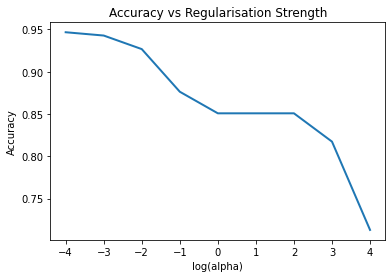

In [11]:
log_alpha=[-4,-3,-2,-1,0,1,2,3,4]
plt.ylabel('Accuracy')
plt.xlabel('log(alpha)')
plt.title('Accuracy vs Regularisation Strength')
plt.plot(log_alpha,cv_scores_bow,linewidth = 2.0 , linestyle="-")
plt.show()

In [12]:
optimal_alpha_bow = alpha_list[cv_scores_bow.index(max(cv_scores_bow))]
print("the optimal value for alpha is :{}".format(optimal_alpha_bow))

the optimal value for alpha is :0.0001


## Predict on test data with best hyper-parameters

In [13]:
#initializing Naive bayes to find test_accuracy with optimal laplace smoothing
SVM_bow = SGDClassifier(loss='hinge',penalty='l2',alpha=optimal_alpha_bow)

#fitting the NB model
SVM_bow.fit(X_train_bow,y_train)

#predicting for test_data 
SVM_pred_bow = SVM_bow.predict(X_test_bow)

SVM_pred_train_bow = SVM_bow.predict(X_train_bow)


#computing accuracy on test_data 
acc_SVM_bow = accuracy_score(y_test,SVM_pred_bow)*100
test_error_bow = (100-acc_SVM_bow)
train_error_bow =( 1-accuracy_score(y_train,SVM_pred_train_bow))*100
                  
                  
print("test accuracy using SVM : {0:.2f}%" .format(round(acc_SVM_bow,2)))
print("test error using SVM : {0:.2f}%" .format(round(test_error_bow,2)))
print("train error using SVM : {0:.2f}%" .format(round(train_error_bow,2)))

test accuracy using SVM : 94.35%
test error using SVM : 5.65%
train error using SVM : 4.52%


In [14]:
#getting precision,recall,f1-score and confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

precision_bow = precision_score(y_test,SVM_pred_bow)*100
recall_bow = recall_score(y_test,SVM_pred_bow)*100
f1_bow = f1_score(y_test,SVM_pred_bow)*100



def confusion_matrix_values(m, n):
    cm = confusion_matrix(m, n)
    return(cm[0][0], cm[0][1],
            cm[1][0], cm[1][1])  


TN, FN, FP, TP = confusion_matrix_values(y_test,SVM_pred_bow)


print("precision score using SVM classifier is : {0:.2f}%".format(round(precision_bow,2)))

print("Recall score using SVM classifier is : {0:.2f}%" .format(round(recall_bow,2)))

print("F1-score using SVM classifier is : {0:.2f}%".format(round(f1_bow,2)))

print('True positive = {}'.format(TP))
print('False positive = {}'.format(FP))
print('False negative = {}'.format(FN))
print('True negative = {}'.format(TN))


precision score using SVM classifier is : 95.34%
Recall score using SVM classifier is : 97.94%
F1-score using SVM classifier is : 96.62%
True positive = 88319
False positive = 1856
False negative = 4318
True negative = 14759


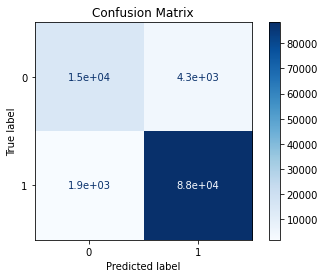

In [15]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(SVM_bow, X_test_bow, y_test,cmap=plt.cm.Blues)  
plt.title('Confusion Matrix')
plt.show() 

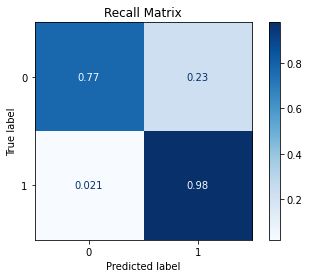

In [16]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(SVM_bow, X_test_bow, y_test,cmap=plt.cm.Blues,normalize='true')  
plt.title('Recall Matrix')
plt.show() 

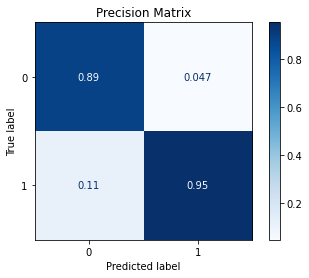

In [17]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(SVM_bow, X_test_bow, y_test,cmap=plt.cm.Blues,normalize='pred') 
plt.title('Precision Matrix')
plt.show() 

## Final Result

In [18]:
#reporting the results in a table
from prettytable import PrettyTable

t= PrettyTable()

t.field_names =["metric/Parameter" , "result"]

t.add_row (["Model" ,"Classification"])
t.add_row (["Classifier" ,"SVM"])
t.add_row  (["Optimal_alpha" , optimal_alpha_bow])
t.add_row(["test accuracy" ,round(acc_SVM_bow,2)])
t.add_row (["Train_error" ,round(train_error_bow,2)])
t.add_row (["Test error" , round(test_error_bow,2)])

In [19]:
print(t)

+------------------+----------------+
| metric/Parameter |     result     |
+------------------+----------------+
|      Model       | Classification |
|    Classifier    |      SVM       |
|  Optimal_alpha   |     0.0001     |
|  test accuracy   |     94.35      |
|   Train_error    |      4.52      |
|    Test error    |      5.65      |
+------------------+----------------+


# Training on TFIDF Features



## Time Based Splitting

In [20]:
#taking first 70% data_points as training data and rest as test_data
X_train_tfidf = text_tf_idf[0:int(final_bigram_counts.shape[0]*0.7)]
X_test_tfidf = text_tf_idf[int(final_bigram_counts.shape[0]*0.7):final_bigram_counts.shape[0]]

y_train = amazon_data["Score"].iloc[0:int(final_bigram_counts.shape[0]*0.7)]
y_test = amazon_data["Score"].iloc[int(final_bigram_counts.shape[0]*0.7):final_bigram_counts.shape[0]]

## Hyper-Parameter Search

In [21]:
alpha_list=[1e-4,1e-3,1e-2,0.1,1,10,100,1000,10000]
cv_scores_tfidf=[]
for i in tqdm(alpha_list):
  clf=SGDClassifier(loss='hinge',penalty='l2',alpha=i)
  scores_tfidf = cross_val_score(clf, X_train_tfidf, y_train, cv=5, scoring='accuracy')
  cv_scores_tfidf.append(scores_tfidf.mean())

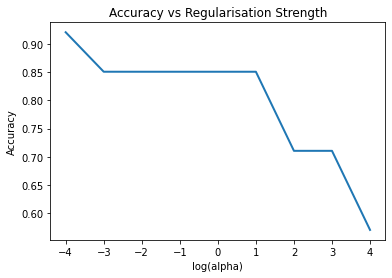

In [22]:
log_alpha=[-4,-3,-2,-1,0,1,2,3,4]
plt.ylabel('Accuracy')
plt.xlabel('log(alpha)')
plt.title('Accuracy vs Regularisation Strength')
plt.plot(log_alpha,cv_scores_tfidf,linewidth = 2.0 , linestyle="-")
plt.show()

In [23]:
optimal_alpha_tfidf = alpha_list[cv_scores_tfidf.index(max(cv_scores_tfidf))]
print("the optimal value for alpha is : {}".format(optimal_alpha_tfidf))

the optimal value for alpha is : 0.0001


## Predict on test data with best hyper-parameters

In [24]:
#initializing Naive bayes to find test_accuracy with optimal laplace smoothing
SVM_tfidf = SGDClassifier(loss='hinge',penalty='l2',alpha=optimal_alpha_tfidf)

#fitting the NB model
SVM_tfidf.fit(X_train_tfidf,y_train)

#predicting for test_data 
SVM_pred_tfidf = SVM_tfidf.predict(X_test_tfidf)

SVM_pred_train_tfidf = SVM_tfidf.predict(X_train_tfidf)


#computing accuracy on test_data 
acc_SVM_tfidf = accuracy_score(y_test,SVM_pred_tfidf)*100
test_error_tfidf = (100-acc_SVM_tfidf)
train_error_tfidf =( 1-accuracy_score(y_train,SVM_pred_train_tfidf))*100
                  
                  
print("test accuracy using SVM : {0:.2f}%" .format(round(acc_SVM_tfidf,2)))
print("test error using SVM : {0:.2f}%" .format(round(test_error_tfidf,2)))
print("train error using SVM : {0:.2f}%" .format(round(train_error_tfidf,2)))

test accuracy using SVM : 91.17%
test error using SVM : 8.83%
train error using SVM : 7.60%


In [25]:
#getting precision,recall,f1-score and confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

precision_tfidf = precision_score(y_test,SVM_pred_tfidf)*100
recall_tfidf = recall_score(y_test,SVM_pred_tfidf)*100
f1_tfidf = f1_score(y_test,SVM_pred_tfidf)*100



def confusion_matrix_values(v, u):
    cm = confusion_matrix(v, u)
    return(cm[0][0], cm[0][1],
            cm[1][0], cm[1][1])  


TN1, FN1, FP1, TP1 = confusion_matrix_values(y_test, SVM_pred_tfidf)


print("precision score using SVM classifier is : {0:.2f}%".format(round(precision_tfidf,2)))

print("Recall score using SVM classifier is : {0:.2f}%" .format(round(recall_tfidf,2)))

print("F1-score using SVM classifier is : {0:.2f}%".format(round(f1_tfidf,2)))

print('True positive = {}'.format(TP1))
print('False positive = {}'.format(FP1))
print('False negative = {}'.format(FN1))
print('True negative = {}'.format(TN1))


precision score using SVM classifier is : 90.66%
Recall score using SVM classifier is : 99.56%
F1-score using SVM classifier is : 94.90%
True positive = 89782
False positive = 393
False negative = 9255
True negative = 9822


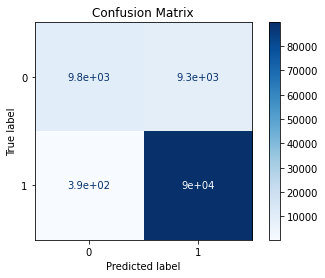

In [26]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(SVM_tfidf, X_test_tfidf, y_test,cmap=plt.cm.Blues)  
plt.title('Confusion Matrix')
plt.show()

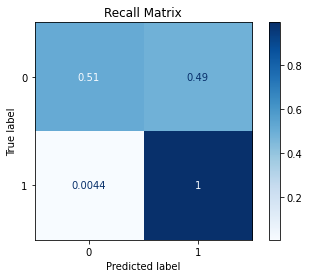

In [27]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(SVM_tfidf, X_test_tfidf, y_test,cmap=plt.cm.Blues,normalize='true')  
plt.title('Recall Matrix')
plt.show() 

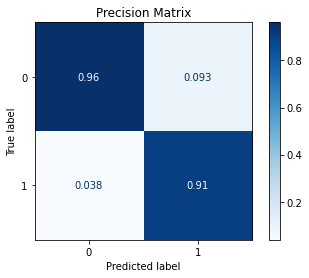

In [28]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(SVM_tfidf, X_test_tfidf, y_test,cmap=plt.cm.Blues,normalize='pred')  
plt.title('Precision Matrix')
plt.show() 

## Final Result

In [29]:
#reporting the results in a table
from prettytable import PrettyTable

t1= PrettyTable()

t1.field_names =["metric/Parameter" , "result"]

t1.add_row(["Model" ,"Classification"])
t1.add_row (["Classifier" ,"SVM"])
t1.add_row  (["Optimal_alpha" , optimal_alpha_tfidf])
t1.add_row(["test accuracy",round(acc_SVM_tfidf,2)])
t1.add_row  (["Train_error" ,round(train_error_tfidf,2)])
t1.add_row  (["Test error" , round(test_error_tfidf,2)])

In [30]:
print(t1)

+------------------+----------------+
| metric/Parameter |     result     |
+------------------+----------------+
|      Model       | Classification |
|    Classifier    |      SVM       |
|  Optimal_alpha   |     0.0001     |
|  test accuracy   |     91.17      |
|   Train_error    |      7.6       |
|    Test error    |      8.83      |
+------------------+----------------+
